referenced from https://ws-choi.github.io/blog-kor/seminar/tutorial/mnist/pytorch/gan/GAN-%ED%8A%9C%ED%86%A0%EB%A6%AC%EC%96%BC/

# Generative Adversarial Network with MNIST dataset

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.utils as utils
import torchvision.datasets as dsets
import torchvision.transforms as transforms

is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

In [2]:
# standardization code
standardizator = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize(mean=(0.5,),   # 3 for RGB channels이나 실제론 gray scale
                                         std=(0.5,))])  # 3 for RGB channels이나 실제론 gray scale

# MNIST dataset
train_data = dsets.MNIST(root='../dataset/', train=True, transform=standardizator, download=True)
test_data  = dsets.MNIST(root='../dataset/', train=False, transform=standardizator, download=True)


batch_size = 100
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size, shuffle=True)
test_data_loader  = torch.utils.data.DataLoader(test_data, batch_size, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../dataset/MNIST/raw/train-images-idx3-ubyte.gz to ../dataset/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../dataset/MNIST/raw/train-labels-idx1-ubyte.gz to ../dataset/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to ../dataset/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../dataset/MNIST/raw



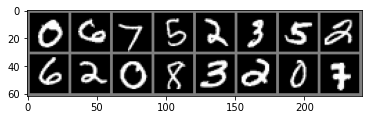

In [3]:
# Visualization
import numpy as np
from matplotlib import pyplot as plt

def imshow(img):
    img = (img+1)/2    
    img = img.squeeze()
    np_img = img.numpy()
    plt.imshow(np_img, cmap='gray')
    plt.show()

def imshow_grid(img):
    img = utils.make_grid(img.cpu().detach())
    img = (img+1)/2
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

example_mini_batch_img, example_mini_batch_label  = next(iter(train_data_loader))
imshow_grid(example_mini_batch_img[0:16,:,:])

In [4]:
example_mini_batch_img.size()

torch.Size([100, 1, 28, 28])

In [5]:
# Simple Generator
d_noise  = 100
d_hidden = 256

G = nn.Sequential(
    nn.Linear(d_noise, d_hidden),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(d_hidden,d_hidden),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(d_hidden, 28*28),
    nn.Tanh()
).to(device)

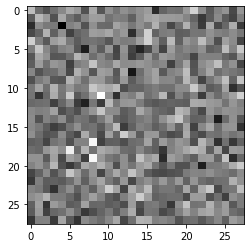

torch.Size([100, 784])


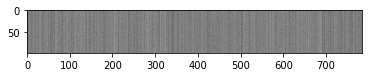

In [6]:
# Genrate Sample
def sample_z(batch_size = 1, d_noise=100):
    return torch.randn(batch_size, d_noise, device=device)

# 노이즈 생성하기
z = sample_z()
# 가짜 이미지 생성하기
img_fake = G(z).view(-1,28,28)
# 이미지 출력하기
imshow(img_fake.squeeze().cpu().detach())

# Batch SIze만큼 노이즈 생성하여 그리드로 출력하기
z = sample_z(batch_size)
img_fake = G(z)
print(img_fake.size())
imshow_grid(img_fake)

In [7]:
# Simple Discriminator
D = nn.Sequential(
    nn.Linear(28*28, d_hidden),
    nn.LeakyReLU(),
    nn.Dropout(0.1),
    nn.Linear(d_hidden, d_hidden),
    nn.LeakyReLU(),
    nn.Dropout(0.1),
    nn.Linear(d_hidden, 1),
    nn.Sigmoid()
).to(device)

print(G(z).shape)
print(D(G(z)).shape)
print(D(G(z)[0:5]).transpose(0,1))

torch.Size([100, 784])
torch.Size([100, 1])
tensor([[0.4844, 0.4828, 0.4857, 0.4882, 0.4846]], device='cuda:0',
       grad_fn=<TransposeBackward0>)


In [62]:
#######################################################
##### EXCERCISE: Custom Generator & Discriminator #####
#######################################################

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.deconv1 = nn.ConvTranspose2d(in_channels=100, out_channels=64, kernel_size=4, stride=2, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.deconv2 = nn.ConvTranspose2d(64, 128, 4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(128)
        self.deconv3 = nn.ConvTranspose2d(128, 1, 7, 3, 0, bias=False)

    def forward(self, x):
        # x: (bs, 100) -> (bs, 100, 1, 1)
        x = x.view(x.size(0), x.size(1), 1, 1)
        # x_1: (bs, 64, 4, 4)
        x = self.relu(self.bn1(self.deconv1(x)))
        # x_2: (bs, 128, 8, 8)
        x = self.relu(self.bn2(self.deconv2(x)))
        # x_3: (bs, 1, 28, 28)
        x = self.tanh(self.deconv3(x))
        # x: (bs, 28*28)
        x = x.view(x.size(0), -1)
        return x

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.relu = nn.LeakyReLU()
        self.conv1 = nn.Conv2d(1, 64, 4, 2, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, 4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 64, 4, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(64)
        self.gap = nn.AvgPool2d((3,3))

        self.fc = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x: (bs, 1, 28, 28)
        x = x.view(x.size(0), -1, 28, 28)

        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.gap(x)
        # binary classification
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = self.sigmoid(x)
        return x

G = Generator().to(device)
D = Discriminator().to(device)
print(G(z).shape)
print()
print(D(G(z)).shape)
print(D(G(z)[0:5]).transpose(0,1))

torch.Size([100, 784])

torch.Size([100, 1])
tensor([[0.4685, 0.5335, 0.4905, 0.5045, 0.4626]], device='cuda:0',
       grad_fn=<TransposeBackward0>)


In [10]:
!pip install torchsummary

In [63]:
from torchsummary import summary
summary(G, (100,))

summary(D, (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1             [-1, 64, 4, 4]         102,400
       BatchNorm2d-2             [-1, 64, 4, 4]             128
              ReLU-3             [-1, 64, 4, 4]               0
   ConvTranspose2d-4            [-1, 128, 8, 8]         131,072
       BatchNorm2d-5            [-1, 128, 8, 8]             256
              ReLU-6            [-1, 128, 8, 8]               0
   ConvTranspose2d-7            [-1, 1, 28, 28]           6,272
       BatchNorm2d-8            [-1, 1, 28, 28]               2
              Tanh-9            [-1, 1, 28, 28]               0
Total params: 240,130
Trainable params: 240,130
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.23
Params size (MB): 0.92
Estimated Total Size (MB): 1.15
-------------------------------------------

In [64]:
criterion = nn.BCELoss()

def run_epoch(generator, discriminator, _optimizer_g, _optimizer_d):

    generator.train()
    discriminator.train()

    for img_batch, label_batch in train_data_loader:

        img_batch, label_batch = img_batch.to(device), label_batch.to(device)

        # ================================================  #
        # maximize V(discriminator,generator) = optimize discriminator (setting k to be 1)  #
        # ================================================  #

        # init optimizer
        _optimizer_d.zero_grad()

        p_real = discriminator(img_batch.view(-1, 28*28))
        p_fake = discriminator(generator(sample_z(batch_size, d_noise)))

        # ================================================  #
        #    Loss computation (soley based on the paper)    #
        # ================================================  #
        loss_real = -1 * torch.log(p_real)   # -1 for gradient ascending
        loss_fake = -1 * torch.log(1.-p_fake) # -1 for gradient ascending
        loss_d    = (loss_real + loss_fake).mean()

        # ================================================  #
        #     Loss computation (based on Cross Entropy)     #
        # ================================================  #
        # loss_d = criterion(p_real, torch.ones_like(p_real).to(device)) + \    #
        #          criterion(p_fake, torch.zeros_like(p_real).to(device))       #

        # Update parameters
        loss_d.backward()
        _optimizer_d.step()

        # ================================================  #
        #        minimize V(discriminator,generator)        #
        # ================================================  #

        # init optimizer
        _optimizer_g.zero_grad()

        p_fake = discriminator(generator(sample_z(batch_size, d_noise)))

        # ================================================  #
        #    Loss computation (soley based on the paper)    #
        # ================================================  #

        # instead of: torch.log(1.-p_fake).mean() <- explained in Section 3
        loss_g = -1 * torch.log(p_fake).mean()

        # ================================================  #
        #     Loss computation (based on Cross Entropy)     #
        # ================================================  #
        # loss_g = criterion(p_fake, torch.ones_like(p_fake).to(device)) #

        loss_g.backward()

        # Update parameters
        _optimizer_g.step()

def evaluate_model(generator, discriminator):

    p_real, p_fake = 0.,0.

    generator.eval()
    discriminator.eval()

    for img_batch, label_batch in test_data_loader:

        img_batch, label_batch = img_batch.to(device), label_batch.to(device)

        with torch.autograd.no_grad():
            p_real += (torch.sum(discriminator(img_batch.view(-1, 28*28))).item())/10000.
            p_fake += (torch.sum(discriminator(generator(sample_z(batch_size, d_noise)))).item())/10000.


    return p_real, p_fake

(epoch 1/50) p_real: 0.359916, p_g: 0.411701
(epoch 2/50) p_real: 0.325383, p_g: 0.628414
(epoch 3/50) p_real: 0.224873, p_g: 0.247408
(epoch 4/50) p_real: 0.145713, p_g: 0.237788
(epoch 5/50) p_real: 0.077060, p_g: 0.518752
(epoch 6/50) p_real: 0.271903, p_g: 0.858078
(epoch 7/50) p_real: 0.283842, p_g: 0.600014
(epoch 8/50) p_real: 0.205726, p_g: 0.390471
(epoch 9/50) p_real: 0.348798, p_g: 0.404138
(epoch 10/50) p_real: 0.503566, p_g: 0.473784


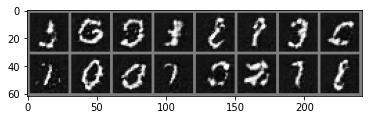

(epoch 11/50) p_real: 0.748957, p_g: 0.683484
(epoch 12/50) p_real: 0.563777, p_g: 0.143515
(epoch 13/50) p_real: 0.401062, p_g: 0.451911
(epoch 14/50) p_real: 0.432757, p_g: 0.455857
(epoch 15/50) p_real: 0.279773, p_g: 0.333040
(epoch 16/50) p_real: 0.338571, p_g: 0.150632
(epoch 17/50) p_real: 0.349636, p_g: 0.287672
(epoch 18/50) p_real: 0.440347, p_g: 0.720369
(epoch 19/50) p_real: 0.418476, p_g: 0.388988
(epoch 20/50) p_real: 0.339322, p_g: 0.392764


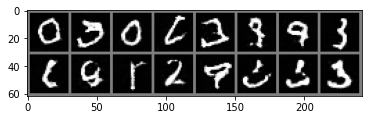

(epoch 21/50) p_real: 0.137660, p_g: 0.147503
(epoch 22/50) p_real: 0.370139, p_g: 0.329983
(epoch 23/50) p_real: 0.759773, p_g: 0.614165
(epoch 24/50) p_real: 0.071817, p_g: 0.081509
(epoch 25/50) p_real: 0.575371, p_g: 0.647496
(epoch 26/50) p_real: 0.395344, p_g: 0.324569
(epoch 27/50) p_real: 0.618634, p_g: 0.458678
(epoch 28/50) p_real: 0.444479, p_g: 0.359528
(epoch 29/50) p_real: 0.250033, p_g: 0.184818
(epoch 30/50) p_real: 0.277435, p_g: 0.241279


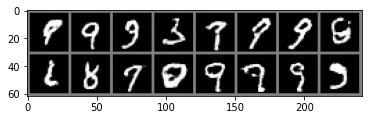

(epoch 31/50) p_real: 0.331141, p_g: 0.365225
(epoch 32/50) p_real: 0.497822, p_g: 0.416541
(epoch 33/50) p_real: 0.296241, p_g: 0.248584
(epoch 34/50) p_real: 0.404733, p_g: 0.256300
(epoch 35/50) p_real: 0.401142, p_g: 0.333751
(epoch 36/50) p_real: 0.108576, p_g: 0.096800
(epoch 37/50) p_real: 0.674032, p_g: 0.519547
(epoch 38/50) p_real: 0.319261, p_g: 0.223379
(epoch 39/50) p_real: 0.535349, p_g: 0.427905
(epoch 40/50) p_real: 0.212507, p_g: 0.143092


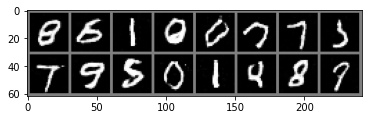

(epoch 41/50) p_real: 0.475224, p_g: 0.336908
(epoch 42/50) p_real: 0.405893, p_g: 0.298377
(epoch 43/50) p_real: 0.693921, p_g: 0.574926
(epoch 44/50) p_real: 0.255693, p_g: 0.148109
(epoch 45/50) p_real: 0.372993, p_g: 0.355143
(epoch 46/50) p_real: 0.116920, p_g: 0.080078
(epoch 47/50) p_real: 0.608044, p_g: 0.443986
(epoch 48/50) p_real: 0.172313, p_g: 0.081742
(epoch 49/50) p_real: 0.112178, p_g: 0.072287
(epoch 50/50) p_real: 0.714576, p_g: 0.586302


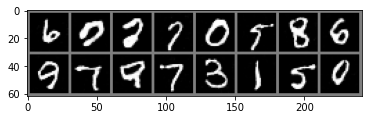

In [65]:
def init_params(model):
    for p in model.parameters():
        if(p.dim() > 1):
            nn.init.xavier_normal_(p)
        else:
            nn.init.uniform_(p, 0.1, 0.2)
            
init_params(G)
init_params(D)

optimizer_g = optim.Adam(G.parameters(), lr = 0.0002, betas=(0.5, 0.999))
optimizer_d = optim.Adam(D.parameters(), lr = 0.0002, betas=(0.5, 0.999))

p_real_trace = []
p_fake_trace = []

epochs = 50 #200
for epoch in range(epochs):

    run_epoch(G, D, optimizer_g, optimizer_d)
    p_real, p_fake = evaluate_model(G,D)

    p_real_trace.append(p_real)
    p_fake_trace.append(p_fake)

    print('(epoch %i/%d) p_real: %f, p_g: %f' % (epoch+1, epochs, p_real, p_fake))
    if (epoch+1) % (epochs//5) == 0:
        imshow_grid(G(sample_z(16)).view(-1, 1, 28, 28))

### End training (Linear model Epoch 200)
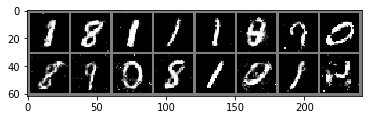

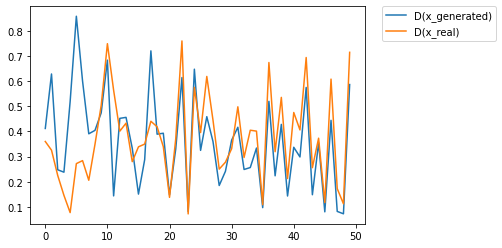

In [66]:
# Probability Tracing
plt.plot(p_fake_trace, label='D(x_generated)')
plt.plot(p_real_trace, label='D(x_real)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

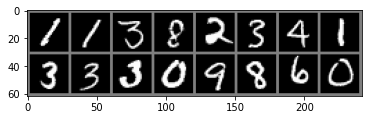

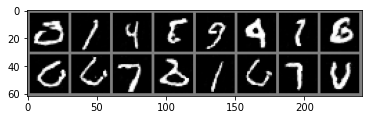

In [67]:
# Comparison with real data
vis_loader = torch.utils.data.DataLoader(test_data, 16, True)
img_vis, label_vis   = next(iter(vis_loader))
imshow_grid(img_vis)

imshow_grid(G(sample_z(16,100)).view(-1, 1, 28, 28))